## This is an example of text classification. In this notebook, I go through a step by step process to build a deep learning model(BiLSTM) using Keras library in Python

In [1]:
# loading general libraries

import pandas as pd
import re
import string
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
pd.set_option('display.max_colwidth', -1)
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/home/anshul.jain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':
/home/anshul.jain/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# loading keras libraries

from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Bidirectional, LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.models import load_model
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input
from tensorflow.keras.layers import *
from keras.models import Model
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

Using TensorFlow backend.


In [3]:
#loading the data set and doing some cleaning and transformations

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
remove_num = re.compile('[0-9]')

def clean_text(text):
    try:
        text = text.lower()
        text = REPLACE_BY_SPACE_RE.sub(' ', text)
        text = BAD_SYMBOLS_RE.sub(' ', text)
        text = remove_num.sub(' ',text)
        word_tokens = word_tokenize(text)
        filtered_sentence = [w for w in word_tokens]# if not w in stop_words]
        text = ' '.join(word for word in filtered_sentence)
        text = text.replace(' p ',' ')

        return text
    except:
        return None
    
df_final = pd.read_csv('Usecase3_Dataset.csv')
df_final = df_final.drop_duplicates()
df_final['final_text'] = df_final['text'].progress_apply(clean_text)
target_names = sorted(list(set(df_final.airline_sentiment)))
print('shape of final dataset:')
print(df_final.shape)

100%|██████████| 14452/14452 [00:02<00:00, 5915.11it/s]

shape of final dataset:
(14452, 4)


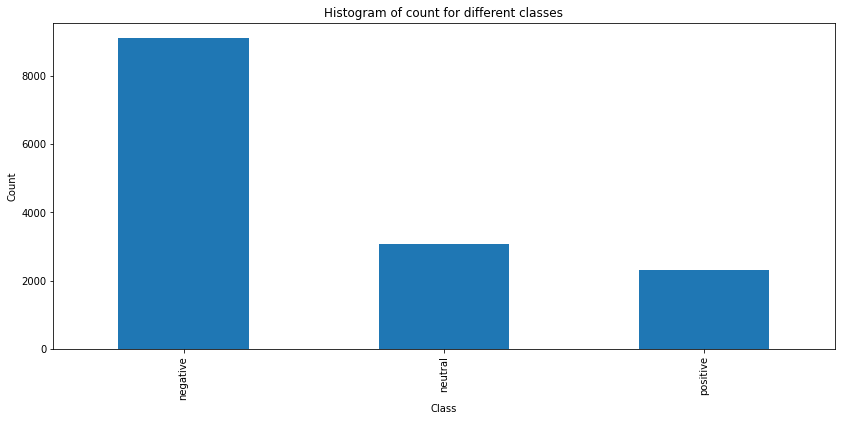

In [4]:
#plot of count of different classes

df_final['airline_sentiment'].value_counts().plot(kind = 'bar', figsize=(14, 6));
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Histogram of count for different classes');

## First I do a basic sentiment analysis exercise using the library Vader in Python

In [6]:
def classify_score(x):
    if x < 0:
        return "negative"
    elif x == 0:
        return "neutral"
    else:
        return "positive"

sid = SentimentIntensityAnalyzer()

df_final['scores'] = df_final['text'].progress_apply(lambda x: sid.polarity_scores(x))
df_final['compound']  = df_final['scores'].progress_apply(lambda x: x['compound'])
df_final['vader_sentiment'] = df_final['compound'].apply(classify_score)

100%|██████████| 14452/14452 [00:00<00:00, 737879.72it/s]


In [7]:
# classification report of analysis using Vader

y = pd.get_dummies(df_final['airline_sentiment']).values
yy = np.argmax(y, axis=1)
y_pred = pd.get_dummies(df_final['vader_sentiment']).values
y_pred_index = np.argmax(y_pred, axis=1)

print(classification_report(yy, y_pred_index,target_names = target_names))

              precision    recall  f1-score   support

    negative       0.90      0.50      0.65      9087
     neutral       0.40      0.42      0.41      3067
    positive       0.33      0.87      0.48      2298

    accuracy                           0.54     14452
   macro avg       0.54      0.60      0.51     14452
weighted avg       0.70      0.54      0.57     14452



## Vader here manages to give an F1 score of 0.54 which is not very high. So I decided to try a bi-LSTM model

## Preparing the data by converting to numerical format

In [8]:
#train_test_split,converting text to numerical content

tokenizer_obj = Tokenizer()

X = df_final['final_text'].values
y = pd.get_dummies(df_final['airline_sentiment']).values
print('Shape of label tensor:', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)
print('Shape of training set:', len(y_train))
print('Shape of test set:', len(y_test))

total_content = df_final['final_text'].values

tokenizer_obj.fit_on_texts(total_content)

# pad sequences

max_length = max([len(s.split()) for s in total_content])

# define vocabulary size 

vocab_size = len(tokenizer_obj.word_index)+1

X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_tokens,maxlen=max_length,padding='post')
X_test_pad = pad_sequences(X_test_tokens,maxlen=max_length,padding='post')

Shape of label tensor: (14452, 3)
Shape of training set: 10116
Shape of test set: 4336


## I use BiLSTM because it has the advantage of reading the text from start to end as well as other way round. Further it's gated structure helps in remembering key information even further away from current word in the sequence. 

## configuration of main model,loss function is categorical_crossentropy for multiclass classification, final activation function is softmax, metric is accuracy 

In [9]:
# main model

input = Input(shape=(max_length,))
model = Embedding(vocab_size,300,input_length=max_length)(input)
model = Bidirectional (LSTM (300,return_sequences=True,dropout=0.5),merge_mode='concat')(model)
model = TimeDistributed(Dense(300,activation='relu'))(model)
model = Flatten()(model)

model = Dense(300,activation='relu')(model)
model = Dense(200,activation='relu')(model)
model = Dense(100,activation='relu')(model)
model = Dense(50,activation='relu')(model)
model = Dense(25,activation='relu')(model)
output = Dense(3,activation='softmax')(model)

model = Model(input,output)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [10]:
model.fit(X_train_pad,y_train, epochs = 10, verbose = 1)

Train on 10116 samples
Epoch 1/10
10116/10116 [==============================] - 48s 5ms/sample - loss: 0.6742 - accuracy: 0.7077
Epoch 2/10
10116/10116 [==============================] - 47s 5ms/sample - loss: 0.4657 - accuracy: 0.8190
Epoch 3/10
10116/10116 [==============================] - 48s 5ms/sample - loss: 0.3344 - accuracy: 0.8723
Epoch 4/10
10116/10116 [==============================] - 49s 5ms/sample - loss: 0.2375 - accuracy: 0.9138
Epoch 5/10
10116/10116 [==============================] - 48s 5ms/sample - loss: 0.1763 - accuracy: 0.9325
Epoch 6/10
10116/10116 [==============================] - 47s 5ms/sample - loss: 0.1349 - accuracy: 0.9529
Epoch 7/10
10116/10116 [==============================] - 47s 5ms/sample - loss: 0.1131 - accuracy: 0.9591
Epoch 8/10
10116/10116 [==============================] - 46s 5ms/sample - loss: 0.0934 - accuracy: 0.9684
Epoch 9/10
10116/10116 [==============================] - 47s 5ms/sample - loss: 0.0729 - accuracy: 0.9768
Epoch 10/10
10

In [11]:
# prediction on test data

yy = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model.predict(X_test_pad)
print(classification_report(yy, np.argmax(y_pred, axis=1),target_names = target_names))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
              precision    recall  f1-score   support

    negative       0.83      0.89      0.86      2726
     neutral       0.61      0.51      0.56       920
    positive       0.69      0.66      0.67       690

    accuracy                           0.77      4336
   macro avg       0.71      0.69      0.70      4336
weighted avg       0.76      0.77      0.76      4336



## The model built here manages to give an F1 score of 0.77 on the test dataset. It is much better than what we got with Vader. Having said that, the F1 score is not very high but it is most likely the best possible with the given dataset, since this is a pretty efficient model for text classification. A K-fold cross validation on different parts of the data set might give slightly variable F1 score though.

## In order to get higher accuracy, either we need more data or we need to use transfer learning techniques such as BERT, etc that can use more relevant embeddings.


## Theme/topic modelling of tweets

In [12]:
#some additional libraries

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
#cleaning functions

def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [14]:
my_stopwords = nltk.corpus.stopwords.words('english')
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning function

def clean_tweet(tweet, bigrams=False):
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = tweet.lower() # lower case
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet) # strip punctuation
    tweet = re.sub('\s+', ' ', tweet) #remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet) # remove numbers
    tweet_token_list = [word for word in tweet.split(' ')
                            if word not in my_stopwords] # remove stopwords
    tweet = ' '.join(tweet_token_list)
    return tweet

In [15]:
df_final['clean_tweet'] = df_final['text'].progress_apply(clean_tweet)

100%|██████████| 14452/14452 [00:00<00:00, 16279.65it/s]


In [16]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.8, min_df=100, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df_final['clean_tweet']).toarray()

# tf_feature_names tells us what word each column in the matrix represents
tf_feature_names = vectorizer.get_feature_names()

In [17]:
number_of_topics = 5
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(tf)

LatentDirichletAllocation(n_components=5, random_state=0)

In [18]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

no_top_words = 6
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,flight,3826.2,service,958.2,thanks,1039.7,thank,583.2,flights,386.9
1,cancelled,1038.2,customer,748.2,back,496.6,would,443.7,airline,384.3
2,delayed,529.9,hold,535.0,get,423.1,like,425.5,fly,375.0
3,plane,508.2,phone,426.0,please,329.6,bag,376.2,way,291.2
4,flightled,499.2,call,370.8,home,287.6,guys,364.0,want,264.9
5,get,361.9,help,363.8,hours,272.4,know,355.2,ticket,249.7


### I tried to model the topic of the tweets using 6 topics. From the table above, it is clear that some of the tweets are about:
#### 1) cancellation or delay of flights 
#### 2) seeking customer service help
#### 3) other flight related issues such as bag, or seeking ticket or expressing gratitude